<h3 align="center"> 3D Volume Registration with Gaussian Process </h3>

Import all required packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.gaussian_process import GaussianProcess

#3. Data Description

We have three series of 3D volumes of pineapples taken by the navigator of the MRI with three different resolutions, 6.4mm, 8mm, and 10mm with known rigid movements. In each series there are four volumes. The first volume is the reference position; the next three volumes are the source volumes, each of which is  rotated 5 degrees along one of the three axis in three dimensional space. 

Volumes are represented as 3D ararys, and volumes with different resolution will have different dimensions (shapes of the arrays). The dimension for 6.4mm resolution is $(40 \times 40 \times40)$, the dimension for 8mm resolution is $(32\times 32 \times 32)$, and the dimension for 10mm resolution is $(26 \times 26 \times 26)$.

## 3.1 Getting Data

The data are complex values directly from the navigator, the navigator has 12 coils each of which takes a 3D volume, and the final volume of the navigator is constructed by the magnitude of the norm over the 12 coils. The functions below reads in data and transform them into volumes that are represented by 3D numpy arrays. 

In [2]:
def clean(lis):
    '''
    Helper function that cleans up list_directory by removing the hidden files
    '''
    try:
         
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

def get_volume(files, voxel):
    '''
    Hepler function for reading in a series of volume given the path and shape information. 
    Transforms the data into 3D array by taking the norm over the 12 coils
    Inputs:
        files - path of a list of files
        voxel - the shape of the volumes in files
    Output:
        a list of volumes from files
    '''
    # read in the raw data
    vol1 = np.memmap(files[4], dtype=np.complex64, mode='c', shape=(12,voxel,voxel,voxel))
    # take the norm
    vol1 = np.array(np.linalg.norm(vol1,axis=0))
    vol2 = np.memmap(files[0], dtype=np.complex64, mode='c', shape=(12,voxel,voxel,voxel))
    vol2 = np.array(np.linalg.norm(vol2,axis=0))
    vol3 = np.memmap(files[2], dtype=np.complex64, mode='c', shape=(12,voxel,voxel,voxel))
    vol3 = np.array(np.linalg.norm(vol3,axis=0))
    vol4 = np.memmap(files[3], dtype=np.complex64, mode='c', shape=(12,voxel,voxel,voxel))
    vol4 = np.array(np.linalg.norm(vol4,axis=0))
    return [vol1, vol2, vol3, vol4]

def get_data():
    '''
    Reads in the volumes from the data directory, transform them to 3D arrays and group them by resolution
    Returns three lists:
    vols_6_4mm - 5 Navigator volumes with 6.4mm resolution
    vols_8mm - 5 Navigator volumes with 8mm resolution
    vols_10mm - 5 Navigator volumes with 10mm resolution
    '''
    
    path = './Volume_Data/'
    
    # create a dictionary to store the different positions for the volumes
    dict_10mm = {}
    dict_6_4mm = {}
    dict_8mm = {}
    
    # traverse through the directory and get all file names
    for root, dirs, files in os.walk(path):
        if len(dirs)==0:
            if('10mm' in root):
                dict_10mm[root] = clean(files)
            if('6_4mm' in root):
                dict_6_4mm[root] = clean(files)
            if('8mm' in root):
                dict_8mm[root] = clean(files)
                
    # create the lists of volumes by resolution
    list_10mm = []
    for item in dict_10mm.iteritems():
        list_10mm.append(os.path.join(item[0],item[1][0]))
    list_10mm.sort()
    vols_10mm = get_volume(list_10mm, 26)
    list_6_4mm = []
    for item in dict_6_4mm.iteritems():
        list_6_4mm.append(os.path.join(item[0],item[1][0]))
    list_6_4mm.sort()
    vols_6_4mm = get_volume(list_6_4mm, 40)
    list_8mm = []
    for item in dict_8mm.iteritems():
        list_8mm.append(os.path.join(item[0],item[1][0]))
    list_8mm.sort()
    vols_8mm = get_volume(list_8mm, 32)
    return vols_6_4mm, vols_8mm, vols_10mm

To run the following cell, please download the data at https://www.dropbox.com/s/w59utbk8jr8rfa6/Volume_Data.zip?dl=0 and save the folder using name `Volume_Data` under the same directory as this ipython notebook.

In [3]:
# Read in all the data and store them by resolution
list_6_4mm, list_8mm, list_10mm = get_data()
print len(list_6_4mm), list_6_4mm[0].shape, len(list_8mm), list_8mm[0].shape, len(list_10mm), list_10mm[0].shape

4 (40, 40, 40) 4 (32, 32, 32) 4 (26, 26, 26)


## 3.2 Visualizing the Data

Below are the orthographic views of the 3D volumes. The plots are labelled with their corresponding resolution. Each column shows the projection of the pineapple along one of the three axis, and each row shows one position of the pineapple. (The difference is very minor because it’s only a 5 degree rotation.)

In [4]:
def plot_volumes(volumes, res):
    '''
    Visualize the input volumes by plotting the orthographic views
    '''
    fig, ax = plt.subplots(4,3)
    fig.set_figwidth(10)
    fig.set_figheight(14)
    [ax[0][i].imshow(volumes[0].max(axis=i),interpolation='None') for i in xrange(3)]
    [ax[0][i].set_title('Position 1 (Reference)') for i in xrange(3)]
    [ax[1][i].imshow(volumes[1].max(axis=i),interpolation='None') for i in xrange(3)]
    [ax[1][i].set_title('Position 2, axis %s' %i) for i in xrange(3)]
    [ax[2][i].imshow(volumes[2].max(axis=i),interpolation='None') for i in xrange(3)]
    [ax[2][i].set_title('Position 3, axis %s' %i) for i in xrange(3)]
    [ax[3][i].imshow(volumes[3].max(axis=i),interpolation='None') for i in xrange(3)]
    [ax[3][i].set_title('Position 4, axis %s' %i) for i in xrange(3)]
    plt.suptitle('%smm Resolution' % res, fontsize=15)
    plt.show()
    plt.close(fig)

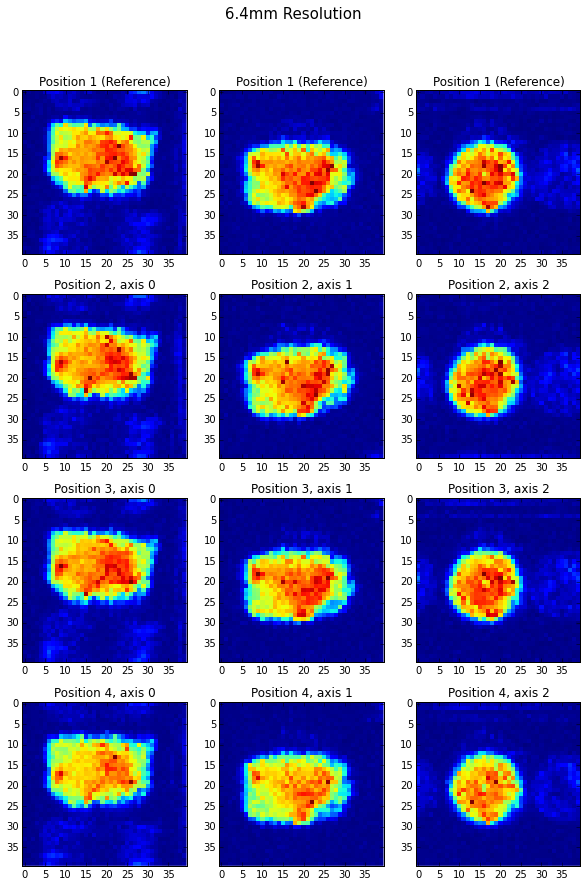

In [5]:
# plot the volumes with different resolution
plot_volumes(list_6_4mm, 6.4)

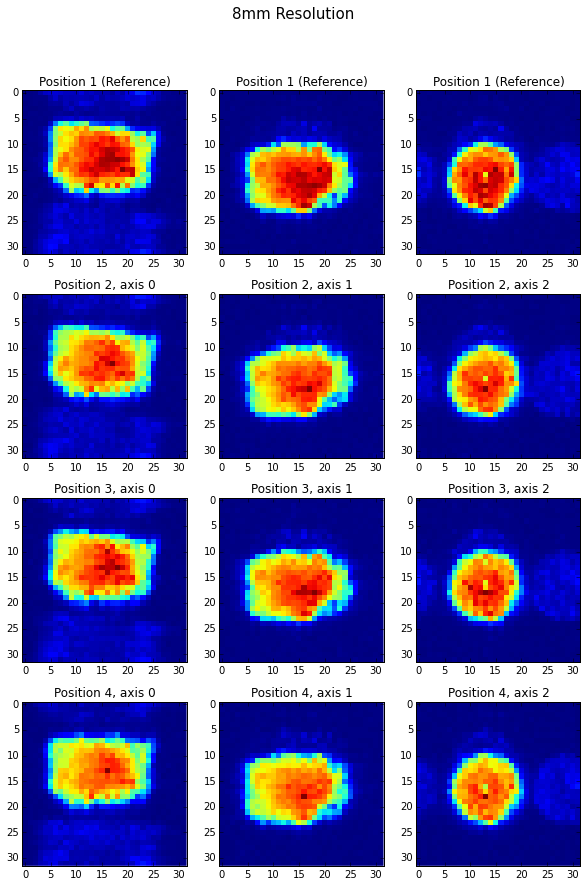

In [6]:
plot_volumes(list_8mm, 8)

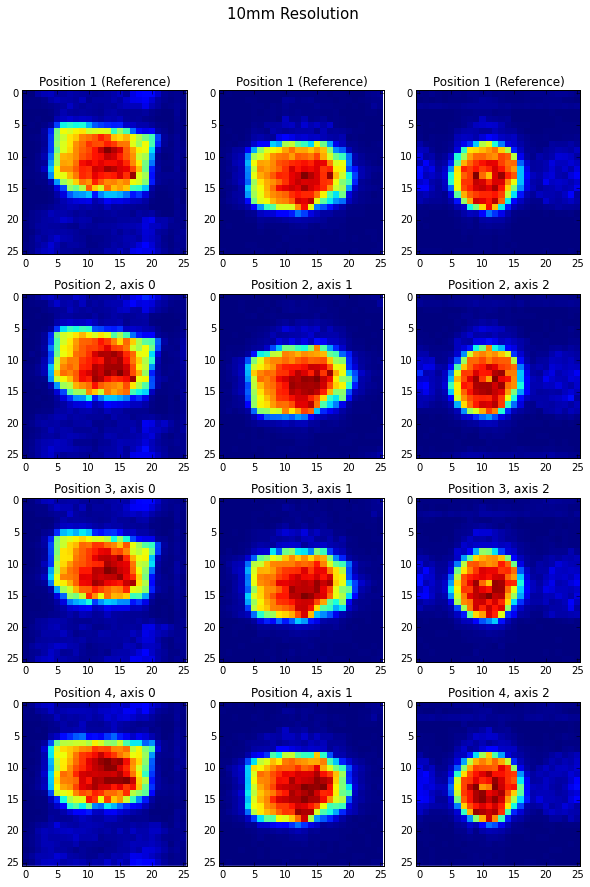

In [7]:
plot_volumes(list_10mm, 10)

The voxel values of the volumes are very small, below are the histograms that shows the distribution of voxel values for the three distributions. Such small number of voxel and low resolution makes it extremely difficult for registration to be accurate.

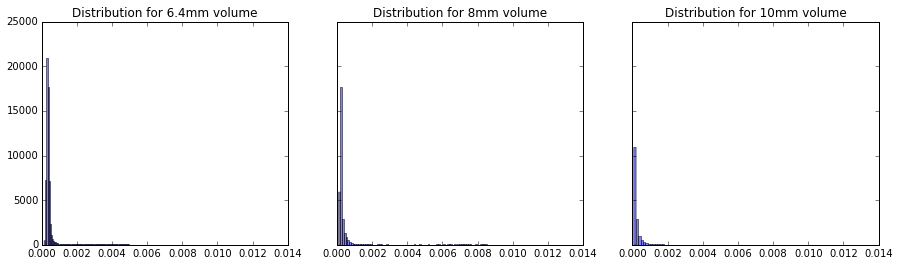

In [8]:
fig, ax = plt.subplots(1,3,sharex=True, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(15)
ax[0].hist(list_6_4mm[0].ravel(), bins=100,alpha=0.5)
ax[0].set_title('Distribution for 6.4mm volume')
ax[1].hist(list_8mm[0].ravel(), bins=100,alpha=0.5)
ax[1].set_title('Distribution for 8mm volume')
ax[2].hist(list_10mm[0].ravel(), bins=100,alpha=0.5)
ax[2].set_title('Distribution for 10mm volume')
plt.show()

#4. Methods
## 4.1. Initial Exploration with Scikit-learn

We know that suppose we have a function vector $ f=(f(x_1),...f(x_n))$, and if for any choice of input points, $(x_1,...,x_n)$, the marginal distribution over f:$P(F) = \int_{f \not\in F} P(f) df$ is multi-variate Gaussian, then the distribution over the function f is said to be a Gaussian Process. To address our problem, we formulate the interpolation using Gaussian Process. Recall that to detect motion, we need to rotate the volumes in positions 2, 3 and 4 and examine how close the rotated volumes are to the reference volume. To rotate a given volume $V$, the first step is to rotate the cartesian grid of the volume, and then the values on the rotated grid need to be interpolated. We will employ a Gaussian process (GP) prior over the volumes and assume Gaussian noise on the observations. Hence the voxel values of the volumes at positinos 2, 3 and 4 serve as observations and use Gaussian Process to predict values on the rotated grids of those volumes.

We define the Gaussian Process for our problem as:

$$f(x) \sim \mathcal{GP}(m(x), k(x,x\prime))$$

where $x$ is the coordinates of the voxels, $f(x)$ is the values at each voxel. The mean and covariance functions can be thought of as the infinite dimensionam mean vector and covariance matrix respectively.

Let's take the size $(32 \times 32 \times32)$ of the volume as an example, the $x$ of the Gaussian Process would be ${(0,0,0), (0,0,1),...,(0,1,0),(0,1,1),...,(31,31,31)}$, which will result in a $(32768 \times 32768)$ covariance matrix. The covariance matrix is too big for our computation, so we reduce the dimensions of the data to speed up computations. The volumes at positions 2, 3, and 4 are rotations along only 1 axis; hence we can slice the volumes into 2D images and run Gaussian Process on the 2D image, which will only have a covariance matrix of size $(1024 \times 1024)$. The code below runs the GP defined above using Scikit-learn.

First, define some helper functions for rotating grids. The rotation matrix in 2D is as follows,

$$R(\theta) = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta \\
\end{bmatrix}$$

If we need to rotate the point (x,y) by $\theta$ degrees counterclock wise, then the coordinates for the new point is 
$(\cos \theta x + \sin\theta y, \sin\theta x+\cos\theta y)$

In [8]:
def to_radian(theta):
    '''
    convert the given theta in degrees to radian
    '''
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta degrees about the
    center(ox, oy).

    """
    # convert
    theta = to_radian(theta)
    s, c = np.sin(theta), np.cos(theta)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

We used scikit learn to try rotations of 45 degrees and visulized the rotated images. There are typically two ways taking 2D slices out of a 3D volume, the first methods is simply to take a slice in one direction out of the volume. THe second methods is called maximum projection, and for 2D maximum projection, each pixel in the projection is the maximum value of the original volume along the orthogonal direction axis of the slice. Maximum prjection produces stronger intensity in the images, given such small pixel values, we will use the maximum projection of the volume to demonstrate the results of Gaussian Process Interpolation. (Please note that we are only using Scikit Learn to get a general idea of how GP works on the volumetric data, hence we will not try to do any registration with scikit learn, only rotations with GP interpolation.)

In [9]:
def generate_X(n):
    '''
    Generate x for Gaussian Process
    Inputs
        n - dimension of volume
    Output:
        X - (n*n, 2) matrix for Gaussian Process
    '''
    X = np.zeros([n*n,2])
    count = 0
    for i in xrange(n):
        for j in xrange(n):
            X[count]=np.array([i,j])
            count += 1
    return X

# generate X_pred
def get_x_pred(theta, n=32):
    '''
    Generate X coordinates for Predictions
    Inputs:
        theta - rotation angle in degrees
        n - image dimension
    Output:
        X_pred - (n*n,2) matrix for prediction
    '''
    # rotate coordinates
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,(n-1.0)/2.0,(n-1.0)/2.0)
    
    # Use the roated coordinates to generate x for prediciton
    X_pred = np.zeros([n*n,2])
    count = 0
    for i in xrange(n):
        for j in xrange(n):
            X_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
            count += 1
    return X_pred

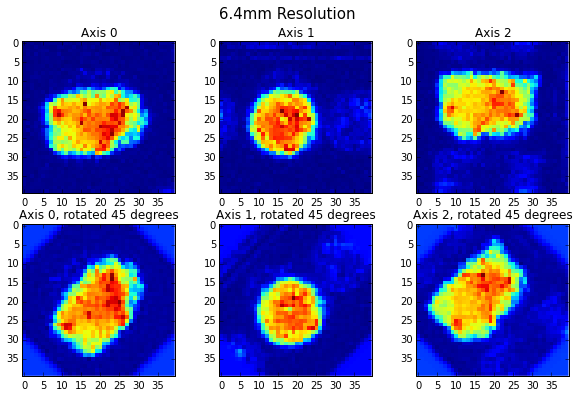

In [11]:
# 6.4mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(40)

# Prediction Coordinates
theta = 45
n = 40
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=10, thetaL=50, thetaU=200)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(list_6_4mm[i].max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = list_6_4mm[i].max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('6.4mm Resolution\n', fontsize=15)
plt.show()

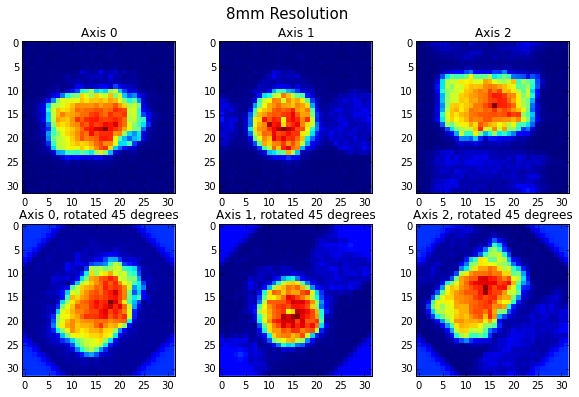

In [10]:
# 8mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(32)

# Prediction Coordinates
theta = 45
n = 32
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=1, thetaL=0.1, thetaU=100)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(list_8mm[i].max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = list_8mm[i].max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('8mm Resolution\n', fontsize=15)
plt.show()

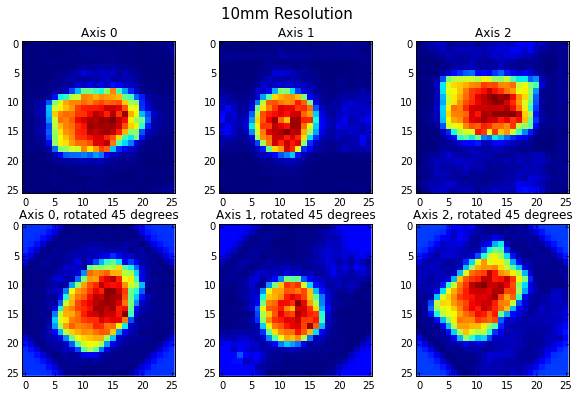

In [11]:
# 10mm Resolution, 45 degree rotation with GP

# Prepare Observations X and Y for GP
X = generate_X(26)

# Prediction Coordinates
theta = 45
n = 26
x_pred = get_x_pred(theta, n)
fig, ax = plt.subplots(figsize=(10,6))

# initialize GP
# train gaussian process on original X and image
# default kernel: squared_exponential
# theta0: parameter of the kernel function. 
# If thetaL and thetaU are also specified, theta0 is considered as the starting point 
# thetaL: lower bound of theta; thetaU: upper bound of theta
gp = GaussianProcess(theta0=1, thetaL=0.1, thetaU=100)

# Run GP for Positions 2, 3, 4
for i in xrange(1,4):
    # Plot the image before rotation
    plt.subplot(2,3,i)
    plt.imshow(list_10mm[i].max(axis=i%3), interpolation='None')
    plt.title("Axis "+`i-1`)
    
    # Run GP to get the rotated image
    Y = list_10mm[i].max(axis=i%3).ravel()
    gp.fit(X, Y)
    y_pred = gp.predict(x_pred)
    
    # Plot the rotated image
    plt.subplot(2,3,3+i)
    plt.imshow(np.reshape(y_pred, (n,n)), interpolation='None')
    plt.title("Axis "+`i-1`+", rotated "+`theta`+" degrees")
    plt.suptitle('10mm Resolution\n', fontsize=15)
plt.show()

## 4.2 Maximum Likelihood of GP

Now that we know how to run Gaussian Process on the data, we decided to implement our own Gaussian Process and find optimal parameters for GP. The kernel function for GP is the squared exponential kernel defined as
$$k(x, x′) = \exp (−l ∥x − x′∥^2).$$ (We have also explored different distance measure in the kernel function, for example L1 distance, cubic distance; however normed distance turned out to be the best measure)

When concerned with a general Gaussian process regression problem, it is assumed that for a Gaussian process f observed at coordinates x, the vector of values $f(x)$ is just one sample from a multivariate Gaussian distribution of dimension equal to number of observed coordinates $|x|$. Therefore under the assumption of a zero-mean distribution, $f (x) ∼ N (0, K(l,x,x'))$, where K(l,x,x') is the covariance matrix between all possible pairs $(x,x')$ for a given $l$. As such the log marginal likelihood is:

\begin{align*}
\log p(f(x)|l,x) =  -\frac{1}{2}f(x)^T K(l,x,x')^{-1} f(x) -\frac{1}{2} \log \det(K(l,x,x')) - \frac{|x|}{2} \log 2\pi 
\end{align*}

We use maximum likelihood estimation to find the optimal $l$. We perform gradient ascend to get the value. First, we calculate the gradient of the log marginal likelihood:
\begin{align*}
\frac{d\log p(f(x)| l, x)}{dl} 
&= \frac{d-\frac{1}{2}f(x)^T K(l,x,x')^{-1} f(x) -\frac{1}{2} \log \det(K(l,x,x')) - \frac{|x|}{2} \log 2\pi }{dl} \\
&= -\frac{1}{2}f(x)^T \frac{d K(l,x,x')^{-1}}{dl} f(x) -\frac{1}{2} \frac{d \log \det(K(l,x,x'))}{dl} \\
&= -\frac{1}{2}f(x)^T (-K(l,x,x')^{-1} \frac{d K(l,x,x')}{dl} K(l,x,x')^{-1}) f(x) -\frac{1}{2} tr(K(l,x,x')^{-1} \frac{d K(l,x,x')}{dl}) \\
&= \frac{1}{2}f(x)^T (K^{-1} \frac{d K}{dl} K^{-1}) f(x) -\frac{1}{2} tr(K^{-1} \frac{d K}{dl})
\end{align*}

First, define functions for the kernel function and calculating covariance matrix.

In [12]:
### define the kernel function
def exponential_kernel(x_1, x_2, l=1.0): 
    return np.exp(np.sum((x_1 - x_2)**2, axis=2) * (-l))

### define the function to get the covariance matrix
def get_cov_matrix(kernel, xx1, xx2, l=1.0):
    xx = np.arange(0, xx1.shape[0])
    yy = np.arange(0, xx2.shape[0])
    mesh_x,mesh_y = np.meshgrid(xx,yy)
    
    sigma = exponential_kernel(xx1[mesh_x], xx2[mesh_y], l)  
    return sigma

Define function that computes the likelihood as defined above. Then use gradient ascend to find $l$ that gives maximum likelihood.

In [13]:
# kernel after gradient
def der_exponential_kernel(x_1, x_2, l): 
    return -np.sum((x_1 - x_2)**2, axis=2)*np.exp( -l* np.sum((x_1 - x_2)**2, axis=2) ) 

# log-likelihood
def Likelihood(X, y, l=1.0, sigma_noise_square=0.1):
    K = get_cov_matrix(exponential_kernel, X,X,l)
    
    sigma_noise_sq = np.ones(K.shape[0])*sigma_noise_square
    K_noise = K + np.diag(sigma_noise_sq)
    
    K_inv = np.linalg.inv(K_noise)
        
    L = np.linalg.cholesky(K)
    log_det = 2*np.sum(np.log(L.diagonal()))

    return -1./2.*np.dot(np.dot(y.T, K_inv), y) - 1./2.*log_det-X.shape[0]/2.*np.log(2*np.pi)

# gradient of log-likelihood
def grad_likelihood(X, Y, l=1.0):
    K_grad = get_cov_matrix(der_exponential_kernel, X, X, l)
    K = get_cov_matrix(exponential_kernel, X, X, l)
    K_inv = np.linalg.inv(K)
    a = np.trace(np.dot(K_inv, K_grad))
    b = np.dot(np.dot(np.dot(np.dot(Y, K_inv), K_grad), K_inv), Y)
    
    return -1./2.*a+1./2.*b

def gradient_ascent(l0, gradient, X, Y, alpha=0.02, sigma_noise_square=0.0):
    l = l0
    l_old = l
    likeli = Likelihood(X, Y, l, sigma_noise_square)
    likelihoods = []
    ls = []
    print "Initial Likelihood:", likeli, "L:", l
    while(True):
        grad = gradient(X, Y, l)
        l_old = l
        likeli_old = likeli
        l += alpha*grad
        count = 1
        
        # l must above zero
        while l<0:
            count+=1
            l = l_old + alpha**count*grad
            
        likeli = Likelihood(X, Y, l, sigma_noise_square)
        
        #print likeli, l
        
        if(abs(likeli_old-likeli)<0.01):
            break
    print "Done!"
    print "Likelihood:", likeli, "L:", l
    return l

In the previous section, we used maximum projection to take a 2D slice out of the 3D volume, however, that method increases the overall intensity of the image, so it cannot be used as a proper representation of the actual volume. Therefore, from now on, we will run tests on simple slices of the volume. For best results, we will take the slice in the middle of the volume.

Run maximum likelihood to find the best parameter $l$

In [15]:
# prepare inputs

# generate X
X = generate_X(32)

# Image at Position 2
Y = list_8mm[3][16,:,:].ravel()

# Reference image
Y_ref = list_8mm[0][16,:,:].ravel()

# Perform Gradient Ascent
l = gradient_ascent(.16, grad_likelihood, X, Y, alpha=0.000003)

Initial Likelihood: -6655.87017783 L: 0.16
Done!
Likelihood: 1460.60132725 L: 0.179858340063


In [18]:
l = 0.179858340063

## 4.3 Implement GP using optimized parameter 

The function below handles GP for 2D image.

In [14]:
# Gaussian processes 
def Gaussian_processes_2D(X, Y, X_pred, l=1.0, sigma_noise_square=0.0):
    '''
    Interpolates a 2D image using GP
    Inputs:
        X - X coordinates of the observation
        Y - Pixel values of the observation
        X_pred - X coordinates of the prediction
        l - parameter for GP
        sigma_noise_square - noise for covariance matrix
    Output:
        y_pred - interpolated image with GP predictions
    '''
    K = get_cov_matrix(exponential_kernel, X,X,l)
    
    # add noise
    sigma_noise_sq = np.ones(K.shape[0])*sigma_noise_square
    K_noise = K + np.diag(sigma_noise_sq)
    
    # inverse of the noise covariance matrix
    K_noise_inv = np.linalg.inv(K_noise)

    K_star = get_cov_matrix(exponential_kernel, X, X_pred, l)
    K_star_star = get_cov_matrix(exponential_kernel, X_pred, X_pred)

    y_pred = np.dot(np.dot(K_star.T, K_noise_inv), Y)
    
    return y_pred

Since we know the movement in the images are 5 degrees, we will use a range of $(5-0.3, 5+0.3)$ to examine the performance of GP. As mentioned above, the cost function we use to compare the rotated image with the reference image is the sum of squared differences (SSD) between the two images. The function belows computes SSD cost function.

In [15]:
# SSD cost function
def cf_ssd(J, I):
    return np.sum((J-I)**2)

8mm resolution is the default resolution for the navigator, so we will first try GP on 8mm resolution. Also, rotation around axis 0 is known to have the most accurate registration results compared to rotation along the other axis, so we
will first try GP using a slice of the 8mm resoluiton volume with rotation along axis 0.

In [16]:
def plot_cost(thetas, costs, res, axis = 0):
    '''
    helper function for plotting cost function.
    '''
    # find the minimum angle
    minAng = thetas[np.argmin(costs)]
    plt.plot(thetas, costs, label='Min Angle = %s degrees' % minAng)
    plt.xlabel('Angles (Degrees)')
    plt.ylabel('SSD')
    plt.title('Cost Function for GP with %smm Resolution, rotation around axis %s' % (res,axis))
    plt.legend()
    plt.show()

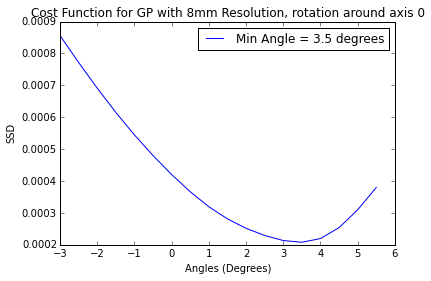

In [20]:
# result of implemented GP

# list of thetas
thetas = np.arange(-3,6,0.5)
# generate X
X = generate_X(32)

# Image at Position 2
Y = list_8mm[3][16,:,:].ravel()

# Reference image
Y_ref = list_8mm[0][16,:,:].ravel()



costs = []
for theta in thetas:
    x_pred = get_x_pred(theta)
    y_pred = Gaussian_processes_2D(X, Y, x_pred, l)
    c =cf_ssd(y_pred, Y_ref)
    costs.append(c)

# plot results 
plot_cost(thetas, costs, 8)

## 4.4 Data Normalization

The reuslt from GP on the sample slice is 3.5 degrees, however we know that true rotation is 5.0 degrees, so we want to further improve the performance of GP. When we imput data into GP, the data was not normalized, and because values for observations are very small (on an average of $1\times 10^{-3}$), such small numbers makes registration very difficult, so we will noralize the data.

The function below runs the same GP with the squared exponential kernel, but with normalized input data.

In [21]:
# Gaussian processes with normalization
def Gaussian_processes_2D_norm(X, Y, X_pred, l=1.0, sigma_noise_square=0.0):
    
    '''
    Interpolates a 2D image using GP with normalization
    Inputs:
        X - X coordinates of the observation
        Y - Pixel values of the observation
        X_pred - X coordinates of the prediction
        l - parameter for GP
        sigma_noise_square - noise for covariance matrix
    Output:
        y_pred - interpolated image with GP predictions with normalization
    '''
    
    # normalize input data
    if Y.ndim == 1:
        Y = Y[:, np.newaxis]
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    X_std[X_std == 0.] = 1.
    Y_std[Y_std == 0.] = 1.
    
    # center and scale
    X_norm = (X - X_mean) / X_std
    Y_norm = (Y - Y_mean) / Y_std
    X_pred_norm = (X_pred - X_mean) / X_std
    
    # Gaussian Process
    K = get_cov_matrix(exponential_kernel, X_norm,X_norm,l)
    
    sigma_noise_sq = np.ones(K.shape[0])*sigma_noise_square
    K_noise = K + np.diag(sigma_noise_sq)
        
    K_noise_inv = np.linalg.inv(K_noise)

    K_star = get_cov_matrix(exponential_kernel,X_norm, X_pred_norm, l)
    K_star_star = get_cov_matrix(exponential_kernel,X_pred_norm, X_pred_norm)

    mu_star = np.dot(np.dot(K_star.T, K_noise_inv), Y_norm)
    
    # scale back to original scale
    Y_pred = mu_star * Y_std + Y_mean
    
    return np.reshape(Y_pred, Y_pred.shape[0])

As before, run Likelihood to find the optimal $l$ before GP.

In [22]:
# generate X
X = generate_X(32)

# Image at Position 2
Y = list_8mm[3][16,:,:].ravel()

# Reference image
Y_ref = list_8mm[0][16,:,:].ravel()

# Normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

In [22]:
# Perform gradient ascent to normed data
l_norm = gradient_ascent(40, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -513.070778688 L: 40
Done!
Likelihood: -573.081099416 L: 36.0734734026


In [23]:
l_norm = 36.0734734026

Below is a demonstration of the GP with normalization. The first plot is the reference image, the second plot is the image of position 2 with a 5-degree rotation, and the thrid plot shows the rotated image using GP. Then cost function will be evaluted on the SSD of reference image and the rotated image. 

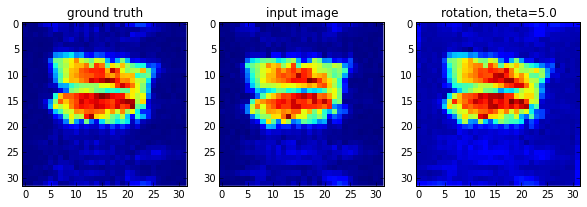

In [24]:
# make sure the GP with Normalization works
# list of thetas
thetas = np.arange(1,6,0.5)
# generate X
X = generate_X(32)

# Image at Position 2
Y = list_8mm[3][16,:,:].ravel()

# Reference image
im_ref = list_8mm[0][16,:,:]

theta = 5.0
n = 32
x_pred = get_x_pred(theta)
y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l_norm)

plt.subplots(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(im_ref, interpolation='None')
plt.title('ground truth')

plt.subplot(1,3,2)
plt.imshow(Y.reshape([32,32]), interpolation='None')
plt.title('input image')

plt.subplot(1,3,3)
im = y_pred.reshape([n,n])
plt.imshow(im, interpolation='None')
plt.title('rotation, theta='+`theta`)
plt.show()

Run the same sample slice as in 4.3 using GP with normalization.

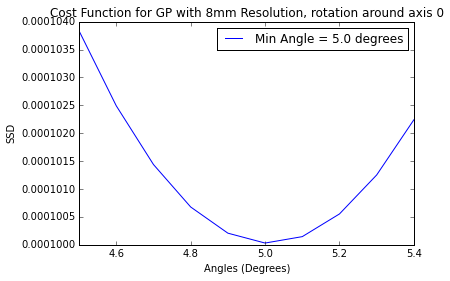

In [24]:
# result of own GP with normaliation
sigma_noise = 0.0
costs = []
thetas = np.arange(4.5,5.5,0.1)
for theta in thetas:
    x_pred = get_x_pred(theta)
    y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l_norm)
    c = cf_ssd(y_pred, Y_ref)
    costs.append(c)

# plot results
plot_cost(thetas, costs, 8)

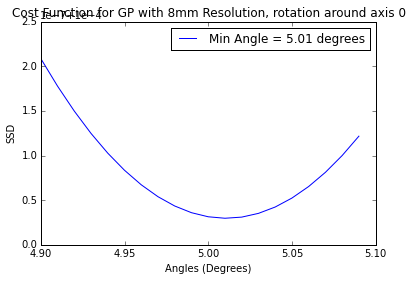

In [28]:
# result of own GP with normaliation
sigma_noise = 0.0
costs = []
thetas = np.arange(4.9,5.1,0.01)
for theta in thetas:
    x_pred = get_x_pred(theta)
    y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l_norm)
    c = cf_ssd(y_pred, Y_ref)
    costs.append(c)

# plot results
plot_cost(thetas, costs, 8)

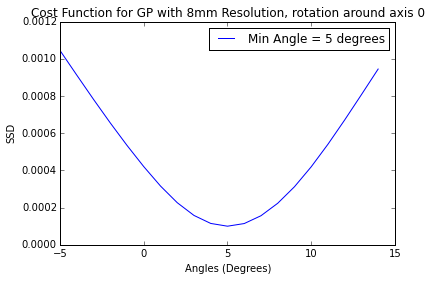

In [26]:
# result of own GP with normaliation
sigma_noise = 0.0
costs = []
thetas = np.arange(-5,15,1)
for theta in thetas:
    x_pred = get_x_pred(theta)
    y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l_norm)
    c = cf_ssd(y_pred, Y_ref)
    costs.append(c)

# plot results
plot_cost(thetas, costs, 8)

With data normalization, we have improved the results and GP can now find the accurate angle (5 degrees) for rotation. We will use this method to run all of the data and compare the accuracy for different resolution.

# 5. Results

In this section, we will show the cost functions for data from all three resolutions and rotations along all axis using the methodology developed above. Recall that in the previous sections, we are using a sample slice of the data, now for the final results, we will run GP with normalization on every slice of the 3D volume to reconstruct the rotated volume in 3D. There will be a total of 9 results, 3 for each resolution, and for each resolution, there is one result for rotation along one axis. The results will be shown by the plot of the cost function, and the angle that gives the minimum cost will be the final result for a rotation in a given resolution.

## 5.1  8mm Resolution
### Rotation along axis 0

In [25]:
# Maximum Likelihood estimation was run in the previous section 8mm resolution
# here we will use the optimal l_norm from section 4.4.
l = l_norm

In [26]:
# 8mm rotation along axis 0
t0 = time.time()

n = 32
s = (n-1)/2.
X = generate_X(n)

# list of thetas
thetas = np.arange(4.6,5.3,0.1)
cost_func_8 = []
vol_ref = list_8mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_8mm[3][idx,:,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[idx,:,:] = y_pred.reshape([n,n])
    cost_func_8.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 time:  92.783796072


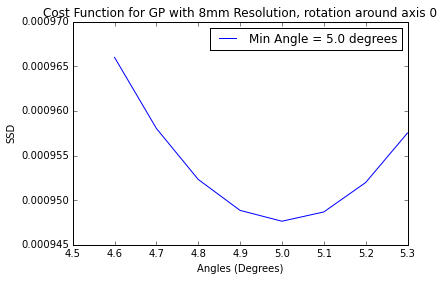

In [27]:
plot_cost(thetas, cost_func_8, 8, 0)

### Rotation along axis 1

In [35]:
n = 32
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(n)

# Image at Position 2
Y = list_8mm[1][:,16,:].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(40, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -704.023568872 L: 40
Done!
Likelihood: -707.20482145 L: 39.918672759


In [36]:
# 8mm rotation along axis 1
t0 = time.time()

n = 32
s = (n-1)/2.
X = generate_X(n)
        
thetas = np.arange(4.3,5.0,0.1)
cost_func_8 = []
vol_ref = list_8mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_8mm[1][:,idx,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with gaussian process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,idx,:] = y_pred.reshape([n,n])
    cost_func_8.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 time:  94.2077507973


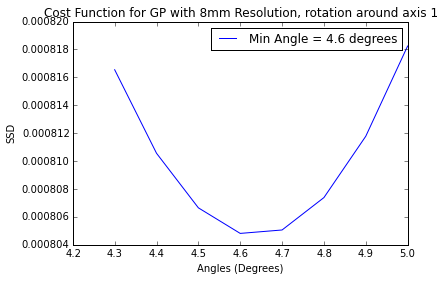

In [37]:
plot_cost(thetas, cost_func_8, 8, axis=1)

### Rotation along axis 2

In [31]:
n = 32
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(n)

# Image at Position 2
Y = list_8mm[2][:,:,16].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(40, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -544.674831191 L: 40
Done!
Likelihood: -611.765262187 L: 37.0949133251


In [32]:
# 8mm rotation along axis 2
t0 = time.time()

n = 32
s = (n-1)/2.
X = generate_X(n)
        
        
thetas = np.arange(4.0,4.4,0.1)
cost_func_8 = []
vol_ref = list_8mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_8mm[2][:,:,idx].ravel()
        
        # Get X
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
        
        # Predict Y with gaussian process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,:,idx] = y_pred.reshape([n,n])
    cost_func_8.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.0 4.1 4.2 4.3 4.4 time:  60.2375791073


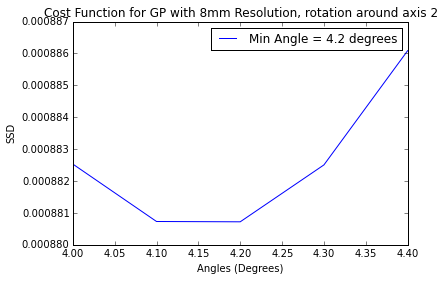

In [33]:
plot_cost(thetas, cost_func_8, 8, axis=2)

## 5.2 6.4mm Resolution
### Rotation along axis 0

Firstly, we run maximum likelihood estimation to find the optimal parameter l.

In [38]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(40)

# Image at Position 2
Y = list_6_4mm[3][20,:,:].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(60, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -1260.10892658 L: 60
Done!
Likelihood: -1119.01571706 L: 63.2232132641


In [39]:
# 6.4mm rotation along axis 0
t0 = time.time()

n = 40
s = (n-1)/2.
X = generate_X(n)
        
thetas = np.arange(4.6,5.3,0.1)
cost_func_6_4 = []
vol_ref = list_6_4mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_6_4mm[3][idx,:,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[idx,:,:] = y_pred.reshape([n,n])
    cost_func_6_4.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 time:  439.046115875


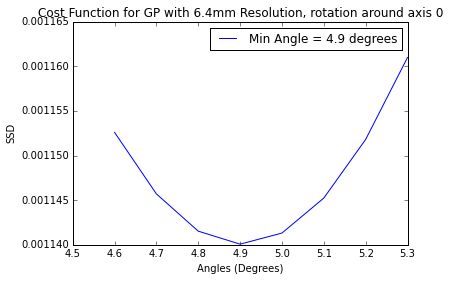

In [40]:
plot_cost(thetas, cost_func_6_4, 6.4, axis=0)

### Rotation along axis 1

In [41]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(40)

# Image at Position 2
Y = list_6_4mm[1][:,20,:].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(60, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -1397.81967913 L: 60
Done!
Likelihood: -1166.01098263 L: 64.8036576625


In [42]:
# 6.4mm rotation along axis 1
t0 = time.time()

n = 40
s = (n-1)/2.
X = generate_X(n)
        
thetas = np.arange(4.6,5.3,0.1)
cost_func_6_4 = []
vol_ref = list_6_4mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_6_4mm[1][:,idx,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,idx,:] = y_pred.reshape([n,n])
    cost_func_6_4.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 time:  454.173367977


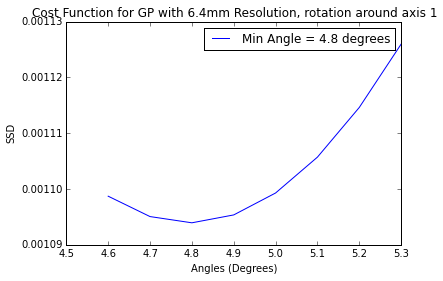

In [43]:
plot_cost(thetas, cost_func_6_4, 6.4, axis=1)

### Rotation along axis 2

In [44]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(40)

# Image at Position 2
Y = list_6_4mm[2][:,:,20].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(60, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -1301.09005226 L: 60
Done!
Likelihood: -1129.00171743 L: 63.5517496069


In [45]:
# 6.4mm rotation along axis 2
t0 = time.time()

n = 40
s = (n-1)/2.
X = generate_X(n)
        
thetas = np.arange(4.6,5.2,0.1)
cost_func_6_4 = []
vol_ref = list_6_4mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_6_4mm[2][:,:,idx].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,:,idx] = y_pred.reshape([n,n])
    cost_func_6_4.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.6 4.7 4.8 4.9 5.0 5.1 5.2 time:  386.934720993


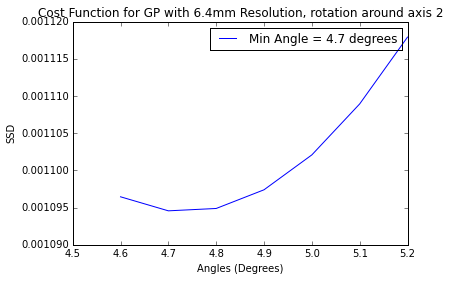

In [46]:
plot_cost(thetas, cost_func_6_4, 6.4, axis=2)

## 5.3 10mm Resolution
### Rotation along axis 0

Again, we first run maximun Likelihood estimation to find the optimal parameter l.

In [47]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(26)

# Image at Position 2
Y = list_10mm[3][13,:,:].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(25, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -329.715282781 L: 25
Done!
Likelihood: -372.435078137 L: 23.4645363231


In [48]:
# 10mm rotation along axis 0

t0 = time.time()

n = 26
s = (n-1)/2.
X = generate_X(n)
        
thetas = np.arange(4.4,5.3,0.1)
cost_func_10 = []
vol_ref = list_10mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_10mm[3][idx,:,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[idx,:,:] = y_pred.reshape([n,n])
    cost_func_10.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 time:  32.1012160778


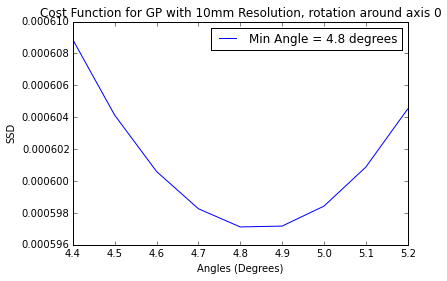

In [49]:
plot_cost(thetas, cost_func_10, 10, axis=0)

### Rotation along axis 1

In [50]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(26)

# Image at Position 2
Y = list_10mm[1][:,13,:].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(25, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -458.947057134 L: 25
Done!
Likelihood: -441.503477354 L: 25.3582636962


In [51]:
# 10mm rotation along axis 1
t0 = time.time()

n = 26
s = (n-1)/2.
X = generate_X(n)    
        
thetas = np.arange(4.3,5.1,0.1)
cost_func_10 = []
vol_ref = list_10mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_10mm[1][:,idx,:].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
                
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,idx,:] = y_pred.reshape([n,n])
    cost_func_10.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 time:  28.0407540798


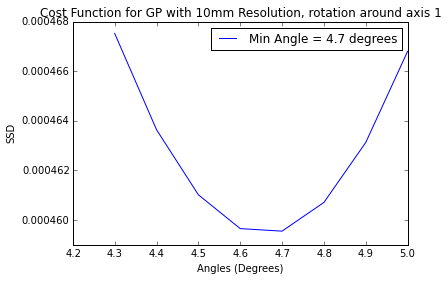

In [52]:
plot_cost(thetas, cost_func_10, 10, axis=1)

### Rotation along axis 2

In [53]:
# Run maximun Likelihood estimation to find the optimal l

# generate X
X = generate_X(26)

# Image at Position 2
Y = list_10mm[2][:,:,13].ravel()

# normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y[:, np.newaxis], axis=0)
Y_std = np.std(Y[:, np.newaxis], axis=0)
X_std[X_std == 0.] = 1.
Y_std[Y_std == 0.] = 1.
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

l = gradient_ascent(25, grad_likelihood, X_norm, Y_norm, alpha=0.002)

Initial Likelihood: -307.250661843 L: 25
Done!
Likelihood: -356.36331504 L: 23.0667497761


In [54]:
# 10mm rotation along axis 2
t0 = time.time()

n = 26
s = (n-1)/2.
X = generate_X(n)

thetas = np.arange(4.2,4.8,0.1)
cost_func_10 = []
vol_ref = list_10mm[0]
for theta in thetas:
    print theta,
    xx = np.linspace(0,n-1,n)
    yy = np.linspace(0,n-1,n)
    mesh_x, mesh_y = np.meshgrid(xx,yy)
    new_vol = np.empty([n,n,n])
    for idx in xrange(n):
        # Get Y
        Y = list_10mm[2][:,:,idx].ravel()
        
        # Get X after rotation
        x_pred_x, x_pred_y = rotate_coords(mesh_x,mesh_y,theta,s,s)
        x_pred = np.zeros([n*n,2])
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                x_pred[count] = np.array([x_pred_y[i,j],x_pred_x[i,j]])
                count += 1
        
        # Predict Y with Gaussian Process
        y_pred = Gaussian_processes_2D_norm(X, Y, x_pred, l)
        new_vol[:,:,idx] = y_pred.reshape([n,n])
    cost_func_10.append(cf_ssd(new_vol, vol_ref))
t1 = time.time()
print 'time: ', t1-t0

4.2 4.3 4.4 4.5 4.6 4.7 time:  20.9005560875


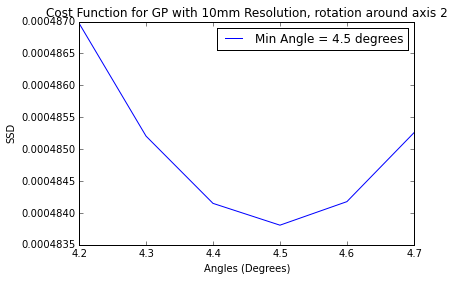

In [55]:
plot_cost(thetas, cost_func_10, 10, axis=2)

Summarize the results for all resolutions and all rotations in the table below for easy reference. 

|                  | axis 0 | axis 1 | axis 2 |
|------------------|--------|--------|--------|
| 6.4mm Resolution | 4.9    | 4.8    | 4.7    |
| 8mm Resolution   | 5.0    | 4.6    | 4.2    |
| 10mm Resolution  | 4.8    | 4.7    | 4.5    |

# 9. References

Wachinger C, Golland P, Reuter M, Wells W. “Gaussian Process Interpolation for Uncertainty Estimation in Image Registration.” Medical image computing and computer-assisted intervention : MICCAI . International Conference on Medical Image Computing and Computer-Assisted Intervention. 2014;17(0 1):267-274.

AM207 Lecture 14 Gaussian Process